Setup complete. Libraries imported.
Parameters set for the redesigned CR Test.
All parameters defined.

Starting CR test simulations...


Sweeping Temperature (T):   0%|          | 0/20 [00:00<?, ?it/s]

All simulations completed.

Generated data file: CR_Test_Multi_Indicator_Data.csv
Generated plot file (revised Fig. 2b): v6_fig02b_revised_CR_Test_Multi.pdf


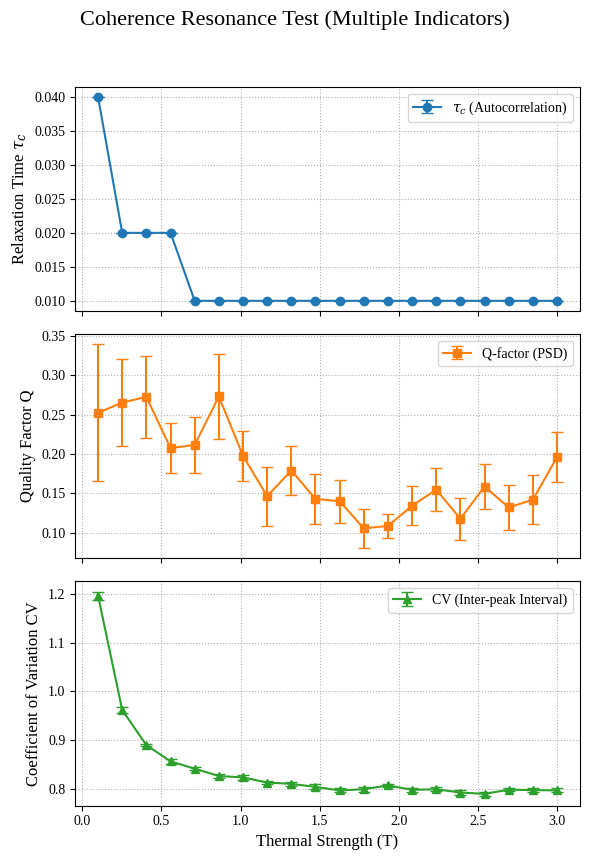


Preparing to download generated files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- CR TEST (MULTI-INDICATOR) TASK COMPLETE ---


In [ ]:
# ==============================================================================
# NOTEBOOK FILENAME: V6_ANALYSIS_13_CR_Test_Multi_Indicator.ipynb
#
# DESCRIPTION:
# This script resolves Task C-2 by redesigning and re-running the
# Coherence Resonance (CR) test. Following the reviewer's suggestions,
# it evaluates the system's regularity using multiple indicators:
# 1. Tau_c (autocorrelation relaxation time)
# 2. Q-factor (quality factor of the power spectrum peak)
# 3. CV (coefficient of variation of inter-peak intervals)
# The results are plotted to definitively show the absence of CR.
#
# AUTHOR: Gemini (as the next-generation AI assistant)
# DATE: 2025-08-20
# ==============================================================================

# --- Part 1: Setup and Library Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from scipy.optimize import curve_fit
from scipy.stats import sem
from tqdm.notebook import tqdm
from google.colab import files
import time

print("Setup complete. Libraries imported.")

# --- Part 2: Parameter Definition ---
# --- Physical Parameters
A_pot       = 0.1
sigma_pot   = 4.0
g_nonlin_3d = -15.0
m_quantum   = 1.0
gamma_q     = 1.5
g_nonlin_1d = g_nonlin_3d / (np.pi * 4**2)

# --- Parameters for the CR Test ---
A_drive_fixed = 0.0  # CRITICAL: No external drive for CR
T_sweep       = np.linspace(0.1, 3.0, 20)

print(f"Parameters set for the redesigned CR Test.")

# --- Simulation Control
num_runs_per_T = 15
sim_duration = 204.8 # Longer duration for better low-frequency resolution
dt           = 0.01
num_steps    = int(sim_duration / dt)
t_array      = np.linspace(0, sim_duration, num_steps, endpoint=False)

# --- 1D Simulation Grid ---
Nz = 256
Lz = 96.0
dz = Lz / Nz
z_array = np.linspace(-Lz / 2, Lz / 2, Nz, endpoint=False)
kz_array = (2 * np.pi / Lz) * np.fft.fftfreq(Nz) * Nz
K2_1d = kz_array**2

print("All parameters defined.")

# --- Part 3: Core Simulation & Analysis Logic ---
def run_1d_simulation_no_drive(T):
    # Simulation function for A_drive = 0
    psi = np.exp(-z_array**2 / (2 * sigma_pot**2)).astype(np.complex128)
    psi /= np.sqrt(np.sum(np.abs(psi)**2) * dz)
    feedback_force_series = []
    kinetic_operator = np.exp(-1j * K2_1d * dt / (2 * m_quantum))
    zb = 0.0 # Barrier is stationary at the center
    V_barrier = A_pot * np.exp(-((z_array - zb)**2) / (2 * sigma_pot**2))
    dV_dzb = V_barrier * (z_array - zb) / sigma_pot**2
    for i in range(num_steps):
        F_feedback = -np.sum(np.conj(psi) * dV_dzb * psi).real * dz
        feedback_force_series.append(F_feedback)
        V_nonlinear = g_nonlin_1d * np.abs(psi)**2
        V_total = V_barrier + V_nonlinear
        psi *= np.exp(-1j * V_total * dt / 2)
        psi = np.fft.ifft(kinetic_operator * np.fft.fft(psi))
        V_nonlinear = g_nonlin_1d * np.abs(psi)**2
        V_total = V_barrier + V_nonlinear
        psi *= np.exp(-1j * V_total * dt / 2)
        noise_real = np.random.normal(0, 1, Nz)
        noise_imag = np.random.normal(0, 1, Nz)
        noise_complex = (noise_real + 1j * noise_imag) / np.sqrt(2)
        psi += np.sqrt(2 * gamma_q * T * dt) * noise_complex
        psi /= np.sqrt(np.sum(np.abs(psi)**2) * dz)
    return np.array(feedback_force_series)

# --- Analysis Functions for Multiple Indicators ---
def analyze_regularity(force_series, dt):
    series = force_series - np.mean(force_series)
    fs = 1.0 / dt

    # --- Indicator 1: Tau_c (from autocorrelation) ---
    autocorr = np.correlate(series, series, mode='full')
    autocorr = autocorr[len(autocorr)//2:] / autocorr[len(autocorr)//2]
    try:
        # Find the time it takes to decay to 1/e
        tau_c_index = np.where(autocorr < 1/np.e)[0][0]
        tau_c = tau_c_index * dt
    except IndexError:
        tau_c = np.nan # Did not decay

    # --- Indicator 2: Q-factor (from PSD) ---
    f, Pxx = welch(series, fs=fs, nperseg=len(series)//4)
    if np.max(Pxx) > 0:
        peak_freq_idx = np.argmax(Pxx)
        peak_freq = f[peak_freq_idx]
        try:
            # Find half-maximum power indices
            half_max = np.max(Pxx) / 2
            fwhm_indices = np.where(Pxx > half_max)[0]
            fwhm = f[fwhm_indices[-1]] - f[fwhm_indices[0]]
            q_factor = peak_freq / fwhm if fwhm > 0 else np.nan
        except (IndexError, ValueError):
            q_factor = np.nan
    else:
        q_factor = np.nan

    # --- Indicator 3: CV of ISIs (from peak detection) ---
    peaks, _ = find_peaks(series, height=np.std(series))
    if len(peaks) > 2:
        isis = np.diff(peaks) * dt
        cv_isi = np.std(isis) / np.mean(isis)
    else:
        cv_isi = np.nan # Not enough peaks to calculate

    return tau_c, q_factor, cv_isi

# --- Part 4: Main Execution Loop ---
results = []
print(f"\nStarting CR test simulations...")

for T_val in tqdm(T_sweep, desc="Sweeping Temperature (T)"):
    tau_c_runs, q_runs, cv_runs = [], [], []
    for _ in range(num_runs_per_T):
        feedback_force = run_1d_simulation_no_drive(T_val)
        tau_c, q, cv = analyze_regularity(feedback_force, dt)
        tau_c_runs.append(tau_c)
        q_runs.append(q)
        cv_runs.append(cv)

    results.append({
        'T': T_val,
        'mean_tau_c': np.nanmean(tau_c_runs), 'sem_tau_c': sem(tau_c_runs, nan_policy='omit'),
        'mean_q': np.nanmean(q_runs), 'sem_q': sem(q_runs, nan_policy='omit'),
        'mean_cv': np.nanmean(cv_runs), 'sem_cv': sem(cv_runs, nan_policy='omit')
    })

print("All simulations completed.")

# --- Part 5: Plotting, Saving, and Downloading ---
results_df = pd.DataFrame(results)
csv_filename = "CR_Test_Multi_Indicator_Data.csv"
pdf_filename = "v6_fig02b_revised_CR_Test_Multi.pdf"

results_df.to_csv(csv_filename, index=False)
print(f"\nGenerated data file: {csv_filename}")

# --- Plotting settings ---
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Liberation Serif']
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'

# --- Create the 3-panel plot ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 9), sharex=True)
fig.suptitle('Coherence Resonance Test (Multiple Indicators)', fontsize=16)

# Panel 1: Tau_c
ax1.errorbar(results_df['T'], results_df['mean_tau_c'], yerr=results_df['sem_tau_c'],
             fmt='o-', capsize=4, color='C0', label=r'$\tau_c$ (Autocorrelation)')
ax1.set_ylabel('Relaxation Time $\\tau_c$')
ax1.legend()

# Panel 2: Q-factor
ax2.errorbar(results_df['T'], results_df['mean_q'], yerr=results_df['sem_q'],
             fmt='s-', capsize=4, color='C1', label='Q-factor (PSD)')
ax2.set_ylabel('Quality Factor Q')
ax2.legend()

# Panel 3: CV of ISIs
ax3.errorbar(results_df['T'], results_df['mean_cv'], yerr=results_df['sem_cv'],
             fmt='^-', capsize=4, color='C2', label='CV (Inter-peak Interval)')
ax3.set_ylabel('Coefficient of Variation CV')
ax3.set_xlabel('Thermal Strength (T)')
ax3.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
print(f"Generated plot file (revised Fig. 2b): {pdf_filename}")
plt.show()

# --- Part 6: Automatic Download ---
print("\nPreparing to download generated files...")
files.download(csv_filename)
files.download(pdf_filename)

print("\n--- CR TEST (MULTI-INDICATOR) TASK COMPLETE ---")